## 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 261kB/s 
     |████████████████████████████████| 460kB 56.0MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1) 데이터 로드하기

In [ ]:
import pickle
with open('/content/drive/MyDrive/DART_project/LSTM훈련용 Dataset/full_df.pkl', 'rb') as f:
    df = pickle.load(f)
import pandas as pd
test = pd.read_csv('/content/drive/MyDrive/DART_project/LSTM훈련용 Dataset/test_dataset_1007.csv')
test
  

,title,label
0,더벨맘스터치 가맹점포 롯데리아 앞질러1위 우뚝,1
1,롯데리아도 맘스터치도 패스트푸드점 위생적발 5년간 50 증가,1
2,맘스터치 도시락 한 달만에 3만개 완판잘 나가는 치킨 프랜차이즈 간편식,0
3,맘스터치 먹고 뉴이스트 · 옹성우 · 여자친구 보러가자,0
4,MTM터치 연중기획공연12세계의 음악도시 오스틴 내슈빌 아바나,0
...,...,...
1495,이천수 2골에도 43 진땀승 장병들에 혼쭐난 2002 스타들,0
1496,비바100 비대면 소비 증가에창업시장 언택트 점포 열풍,1
1497,맘스터치 여름 보양식 삼계탕’으로 가정간편식 시장 출격,0
1498,대구시 국내 최대규모 프랜차이즈 창업박람회 열려,0


In [ ]:
for i in range(len(test)):
  import re
  new_sentence = 0
  new_sentence = re.sub('[↓▼]', '하락',test.title[i])
  new_sentence = re.sub('[↑▲]', '상승',new_sentence)
  new_sentence = re.sub('[→]', '에서',new_sentence)
  new_sentence
  test.title[i] = new_sentence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df.rename({'title':'document'},axis=1,inplace=True)

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f367a1c9e50>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data = df.copy()
train_data.rename({'title':'document'},axis=1,inplace=True)
test_data = test.copy()
test_data.rename({'title':'document'},axis=1,inplace=True)

In [ ]:
print('훈련용 리뷰 개수 :', len(train_data))

훈련용 리뷰 개수 : 7118


In [ ]:
train_data[:5]

,document,label
0,버거킹 바삭한 신메뉴 3000원도 안되는 가격,1
1,버거킹 가을 맞이 와퍼주니어 1900원 판매,0
2,귀엽거나 오싹하거나’할로윈데이 겨냥한 이색 식음료 출시,1
3,버거킹 몬스터X의 할로윈 에디션 스크림몬스터X 출시,1
4,햄버거 브랜드 버거킹 치킨 사이드 신메뉴 바삭킹 선보여,1


In [ ]:
print('테스트용 리뷰 개수 :', len(test_data))

테스트용 리뷰 개수 : 1500


In [ ]:
test_data[:5]

,document,label
0,더벨맘스터치 가맹점포 롯데리아 앞질러1위 우뚝,1
1,롯데리아도 맘스터치도 패스트푸드점 위생적발 5년간 50 증가,1
2,맘스터치 도시락 한 달만에 3만개 완판잘 나가는 치킨 프랜차이즈 간편식,0
3,맘스터치 먹고 뉴이스트 · 옹성우 · 여자친구 보러가자,0
4,MTM터치 연중기획공연12세계의 음악도시 오스틴 내슈빌 아바나,0


#### 2) 데이터 정제하기

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(5937, 3)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 5937


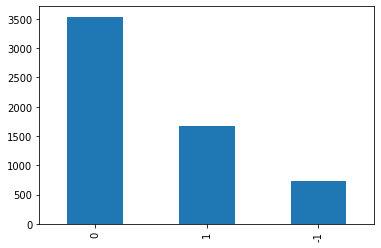

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0     -1    723
1      0   3536
2      1   1678


In [ ]:
print(train_data.isnull().values.any())

False


In [ ]:
print(train_data.isnull().sum())

document    0
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.label.isnull()]

,document,label


In [ ]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data))

5937


In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,document,label
0,버거킹 바삭한 신메뉴 원도 안되는 가격,1
1,버거킹 가을 맞이 와퍼주니어 원 판매,0
2,귀엽거나 오싹하거나할로윈데이 겨냥한 이색 식음료 출시,1
3,버거킹 몬스터의 할로윈 에디션 스크림몬스터 출시,1
4,햄버거 브랜드 버거킹 치킨 사이드 신메뉴 바삭킹 선보여,1


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    2
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,document,label
1537,NaN,0
3962,NaN,0


In [ ]:
train_data = train_data.dropna(how='any')
print(len(train_data))

5935


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1093


#### 3) 토큰화

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
X_train = []
for sentence in train_data['document']:
  temp_X = okt.morphs(sentence, stem=True)
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  X_train.append(temp_X)

In [ ]:
len(X_train)

5935

In [ ]:
print(X_train[:3])

[['버거킹', '바삭', '신', '메뉴', '원도', '안되다', '가격'], ['버거킹', '가을', '맞이', '와퍼주니어', '원', '판매'], ['귀엽다', '오싹하다', '할로윈데이', '겨냥', '이색', '식', '음료', '출시']]


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
print(X_test[:3])

[['더벨맘스', '터치', '가맹', '점포', '롯데리아', '앞', '지르다', '위', '우뚝'], ['롯데리아', '맘스터치', '패스트푸드', '점', '위생', '적발', '년', '간', '증가'], ['맘스', '터치', '도시락', '달', '만에', '만', '개', '완판잘', '나가다', '치킨', '프랜차이즈', '간편식']]


In [ ]:
len(X_test)

1093

### 4) 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'버거킹': 1, '현': 2, '조선': 3, '포': 4, '대미': 5, '승리': 6, '라멘': 7, '원': 8, '와퍼': 9, '떡볶이': 10, '출시': 11, '대': 12, '아': 13, '할인': 14, '오리': 15, '월': 16, '국': 17, '대표': 18, '메뉴': 19, '일': 20, '로': 21, '넷마블': 22, '버거': 23, '이벤트': 24, '햄버거': 25, '년': 26, '억': 27, '삼성': 28, '점주': 29, '선': 30, '전자': 31, '판매': 32, '전': 33, '개': 34, '킹': 35, '매출': 36, '수주': 37, '종': 38, '진행': 39, '만': 40, '집': 41, '가격': 42, '까지': 43, '에서': 44, '위': 45, '등': 46, '가맹': 47, '프로모션': 48, '논란': 49, '배달': 50, '행사': 51, '억원': 52, '광고': 53, '브랜드': 54, '세트': 55, '되다': 56, '인상': 57, '서': 58, '몬스터': 59, '실시': 60, '규모': 61, '버닝썬': 62, '척': 63, '을': 64, '신': 65, '창업': 66, '시장': 67, '사': 68, '데이': 69, '맥도날드': 70, '보다': 71, '오늘': 72, '수': 73, '인기': 74, '먹다': 75, '프리미엄': 76, '상승': 77, '짜다': 78, '십': 79, '올': 80, '업계': 81, '일절': 82, '무료': 83, '김상현': 84, '없다': 85, '서비스': 86, '하락': 87, '운반': 88, '오': 89, '주': 90, '글로벌': 91, '이다': 92, '최대': 93, '와퍼주니어': 94, '기념': 95, '고기': 96, '치킨': 97, '대상': 98, '점': 99, '돌파': 100, '프랜차이즈': 101, '매장'

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6809
등장 빈도가 2번 이하인 희귀 단어의 수: 4012
단어 집합에서 희귀 단어의 비율: 58.9220149801733
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.89492119089317


In [ ]:
# 전체 단어 개수 중 빈도수 2 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 2798


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[1, 197, 65, 19, 1873, 42], [1, 560, 191, 94, 8, 32], [2209, 955, 956, 364, 198, 274, 11]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
len(y_train)

5935

### 5) 빈 샘플(empty samples) 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

5933
5933


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 6) 패딩

리뷰의 최대 길이 : 20
리뷰의 평균 길이 : 8.768076858250463


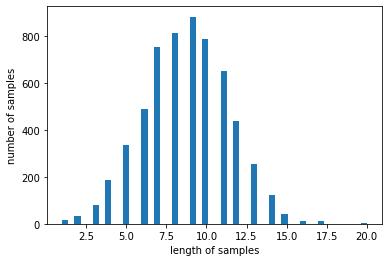

In [ ]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
len(y_train)

5933

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
80/80 [==============================] - 18s 13ms/step - loss: 0.1777 - acc: 0.6702 - val_loss: 4.2234 - val_acc: 0.2923

Epoch 00001: val_acc improved from -inf to 0.29233, saving model to best_model.h5
Epoch 2/15
80/80 [==============================] - 0s 6ms/step - loss: -2.0867 - acc: 0.7952 - val_loss: 1.8053 - val_acc: 0.3530

Epoch 00002: val_acc improved from 0.29233 to 0.35299, saving model to best_model.h5
Epoch 3/15
80/80 [==============================] - 0s 6ms/step - loss: -0.6550 - acc: 0.7610 - val_loss: 1.5270 - val_acc: 0.4027

Epoch 00003: val_acc improved from 0.35299 to 0.40270, saving model to best_model.h5
Epoch 4/15
80/80 [==============================] - 0s 6ms/step - loss: -4.1520 - acc: 0.8303 - val_loss: 2.9843 - val_acc: 0.3951

Epoch 00004: val_acc did not improve from 0.40270
Epoch 5/15
80/80 [==============================] - 0s 6ms/step - loss: -5.6157 - acc: 0.8517 - val_loss: 2.8934 - val_acc: 0.4364

Epoch 00005: val_acc improved from 0.

array([[   0,    0,    0, ..., 2320,   45, 2048],
       [   0,    0,    0, ...,   26,  185,  279],
       [   0,    0,    0, ...,   97,  101, 1465],
       ...,
       [   0,    0,    0, ..., 1465,   67, 1351],
       [   0,    0,    0, ...,   66, 1235, 1819],
       [   0,    0,    0, ...,  364,   65,   19]], dtype=int32)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

35/35 [==============================] - 0s 2ms/step - loss: -0.4967 - acc: 0.8737

 테스트 정확도: 0.8737


## 3. 리뷰 예측해보기

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print(score)
  

In [ ]:
sentiment_predict('안전사고')

3.934744796652012e-08


3.934744796652012e-08

In [ ]:
sentiment_predict('별로예요')

99.98% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('굳굳')

99.98% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('핵노잼 ㅠㅠ')

99.98% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('뭐냐이게')

100.00% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('상승')

99.99% 확률로 부정 리뷰입니다.

